In [1]:

import os
import time
import numpy as np

import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

print()

# check if GPU is available
if torch.cuda.is_available(): 
    print('    > Ok GPU')
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("    > Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

print()



    > Warning: CUDA not found, CPU only.




## Loading data and creating datasets


In [2]:

data_dir = 'mednist' 
class_names = os.listdir(data_dir)
nb_classes = len(class_names)      
images = [[os.path.join(data_dir, class_names[i],x) for x in os.listdir(os.path.join(data_dir, class_names[i]))] for i in range(nb_classes)]                     
nb_labels = [len(images[i]) for i in range(nb_classes)]
img_files = []              
labels = []   

for i in range(nb_classes):
    img_files.extend(images[i])
    labels.extend([i] * nb_labels[i])
    
total = len(labels)      
img_width, img_height = Image.open(img_files[0]).size        

print()
print("    There are", total, "images in", nb_classes, "distinct categories")
print("    Label names:", class_names)
print("    Label counts:", nb_labels)
print("    Image dimensions:", img_width, "x", img_height)
print()



    There are 58954 images in 6 distinct categories
    Label names: ['BreastMRI', 'ChestCT', 'HeadCT', 'Hand', 'AbdomenCT', 'CXR']
    Label counts: [8954, 10000, 10000, 10000, 10000, 10000]
    Image dimensions: 64 x 64



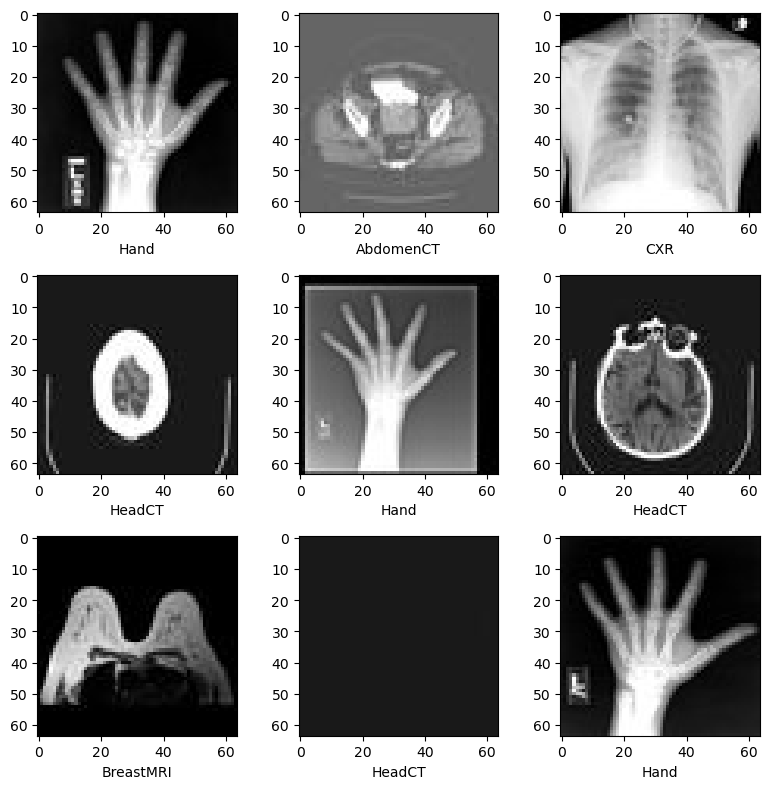

In [3]:

mp.subplots(3, 3, figsize = (8, 8))

for i, k in enumerate(np.random.randint(total, size = 9)):  
    img = Image.open(img_files[k])                      
    arr = np.array(img)
    mp.subplot(3, 3, i + 1)
    mp.xlabel(class_names[labels[k]])
    mp.imshow(arr, cmap = 'gray', vmin = 0, vmax = 255)
    
mp.tight_layout()
mp.show()




## Transforming data and partitioning into training, validation and testing sets



In [4]:

to_tensor = tv.transforms.ToTensor()

# pass a PIL image, return a tensor
def scale_image(x):          
    y = to_tensor(x)
    
    if (y.min() < y.max()):  
        y = (y - y.min()) / (y.max() - y.min()) 
        
    z = y - y.mean()        
    
    return z

img_tensor = torch.stack([scale_image(Image.open(x)) for x in img_files]) 
class_tensor = torch.tensor(labels)  

print()
print("    Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}".format(img_tensor.min().item(), img_tensor.max().item(), img_tensor.mean().item()))
print()



    Rescaled min pixel value = -0.786; Max = 0.972; Mean = -2.46e-09



In [9]:

# define the fraction of images to move to validation dataset
valid_frac = 0.1
# Define the fraction of images to move to test dataset
test_frac = 0.1    
train_list = []
test_list = []
valid_list = []

for i in range(total):
    # randomly reassign images
    _random = np.random.random() 
    if _random < valid_frac:
        valid_list.append(i)
    elif _random < test_frac + valid_frac:
        test_list.append(i)
    else:
        train_list.append(i)

# count the number in each set
nb_train = len(train_list)
nb_test = len(test_list)
nb_valid = len(valid_list)

print()
print("    Training images = ", nb_train, "\n    Validation = ", nb_valid, "\n    Testing = ", nb_test)
print()



    Training images =  47388 
    Validation =  5770 
    Testing =  5796



In [10]:

# slice the big image and label tensors up into
train_ids = torch.tensor(train_list)

# training, validation, and testing tensors
test_ids = torch.tensor(test_list)
valid_ids = torch.tensor(valid_list)    

train_X = img_tensor[train_ids,:,:,:]
train_Y = class_tensor[train_ids]

test_X = img_tensor[test_ids,:,:,:]
test_Y = class_tensor[test_ids]

valid_X = img_tensor[valid_ids,:,:,:]
valid_Y = class_tensor[valid_ids]



## Model Architecture


In [16]:

class MedNet(nn.Module):
    # pass image dimensions and number of labels when initializing a model 
    def __init__(self, x_dim, y_dim, num_c):
        # extends the basic nn.Module to the MedNet class
        super(MedNet,self).__init__()  
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(x_dim-(convSize1-1)-(convSize2-1))*(y_dim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC, fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2, num_c)
        
    def forward(self, x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        
        return x

    # count the individual nodes in a layer
    def num_flat_features(self, x):  
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
            
        return num_features



## Training the Model


In [21]:

model = MedNet(img_width, img_height, nb_classes).to(dev)

learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nb_train // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nb_valid // batchSize       # Validation batches. Round down
testBats = -(-nb_test // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(nb_classes)     # This takes into account the imbalanced dataset.

for i in train_Y.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * nb_classes / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nb_train)  # Shuffle data to randomize batches
    train_X = train_X[permute,:,:,:]
    train_Y = train_Y[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = train_X[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = train_Y[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nb_valid)  # We go through the exact same steps, without backprop / optimization
    validX = valid_X[permute,:,:,:]    # in order to evaluate the validation loss
    validY = valid_Y[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = valid_X[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = valid_Y[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break


Epoch =   0; Training loss = 0.6035; Validation loss = 0.1794
Epoch =   1; Training loss = 0.1528; Validation loss = 0.1099
Epoch =   2; Training loss = 0.0999; Validation loss = 0.0747
Epoch =   3; Training loss = 0.0690; Validation loss = 0.0525
Epoch =   4; Training loss = 0.0504; Validation loss = 0.0409
Epoch =   5; Training loss = 0.0393; Validation loss = 0.0324
Epoch =   6; Training loss = 0.0316; Validation loss = 0.0277
Epoch =   7; Training loss = 0.0267; Validation loss = 0.0240
Epoch =   8; Training loss = 0.0226; Validation loss = 0.0218
Epoch =   9; Training loss = 0.0199; Validation loss = 0.0205
Epoch =  10; Training loss = 0.0176; Validation loss = 0.0170
Epoch =  11; Training loss = 0.0157; Validation loss = 0.0162
Epoch =  12; Training loss = 0.0139; Validation loss = 0.0152
Epoch =  13; Training loss = 0.0126; Validation loss = 0.0146
Epoch =  14; Training loss = 0.0117; Validation loss = 0.0141
Epoch =  15; Training loss = 0.0105; Validation loss = 0.0124
Epoch = 


## Testing the Model on New Data


In [23]:

confuseMtx = np.zeros((nb_classes, nb_classes), dtype=int)  # Create empty confusion matrix

model.eval()

with torch.no_grad():
    permute = torch.randperm(nb_test)                     # Shuffle test data
    test_X = test_X[permute,:,:,:]
    test_Y = test_Y[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = test_X[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = test_Y[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
            
correct = sum([confuseMtx[i,i] for i in range(nb_classes)])   # Sum over diagonal elements to count correct predictions

print()
print("    > Correct predictions: ", correct, "of", nb_test)
print()
print("    Confusion Matrix:")
print(confuseMtx)
print()
print(class_names)
print()



    > Correct predictions:  5780 of 5796

    Confusion Matrix:
[[ 864    1    0    0    0    0]
 [   1 1042    0    0    1    0]
 [   0    0  975    1    1    0]
 [   0    0    2  957    0    0]
 [   0    5    0    0  955    0]
 [   0    0    0    4    0  987]]

['BreastMRI', 'ChestCT', 'HeadCT', 'Hand', 'AbdomenCT', 'CXR']



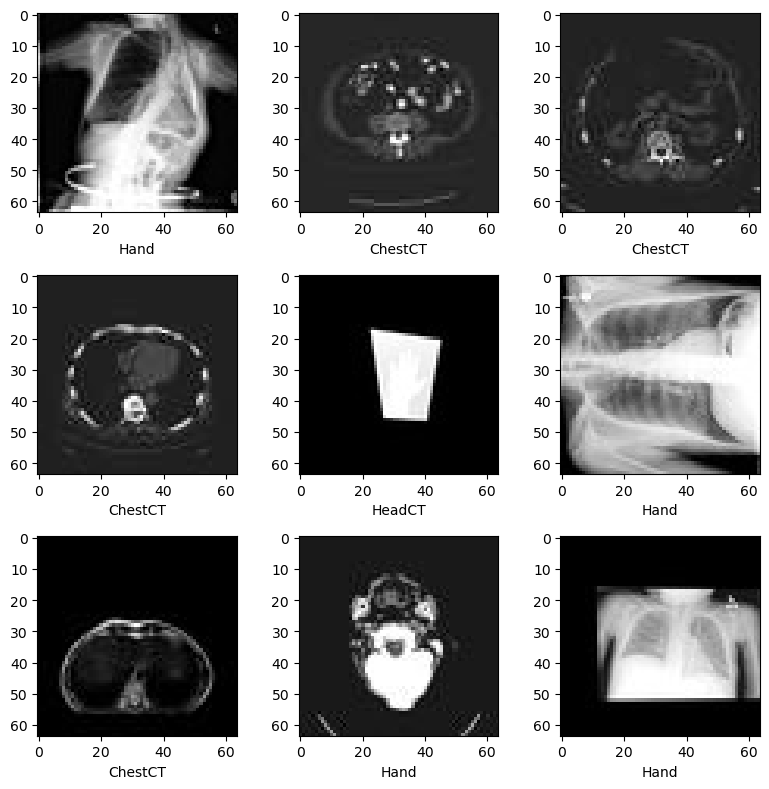

In [27]:

def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()

mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nb_test)        # Shuffle test data
test_X = test_X[permute,:,:,:]
test_Y = test_Y[permute]

for j in range(testBats):              # Iterate over test batches
    batX = test_X[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = test_Y[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(class_names[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
            
mp.tight_layout()
mp.show()


In [26]:

torch.save(model, 'mednist_model')
